In [91]:
# Plotting
import matplotlib.pyplot as plt

# Data handling
import pandas as pd
import numpy as np

# Machine learning modeling
from sklearn.datasets import fetch_kddcup99
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Get data

## Fetch data from Sklearn repositories

Obtain data from Skearn datasets and saves it into a parque file for later use. This allows to save some memory space when dealing with large datasets.

In [92]:
reload_data = False

if reload_data:
    # Load the KDD Cup 99 10% dataset
    kddcup99_data = fetch_kddcup99(percent10=True)
    
    # Create a DataFrame
    df = pd.DataFrame(kddcup99_data.data, columns=kddcup99_data.feature_names)
    df['target'] = kddcup99_data.target
    
    # Filter by 'smurf' and 'normal' attacks. These are the only types of attacks that will be considered in this code.
    df_filtered = df[df['target'].isin([b'smurf.', b'normal.'])]
    df_filtered.to_parquet('data/kddcup99_data_smurf_&_normal.parquet')
else:
    df_smurf = pd.read_parquet('data/kddcup99_data_smurf_&_normal.parquet')

# Create distribtions for Agent-based Modeling

This code analyzes the data and finds the most relevant variables to predict whether an entry is a smurf attack or not. For each of these variables, we will find a distribution that can be used to model agents that simulate the behavior of attackers.

## Get most relevante variables

In [93]:
# Encode categorical variables
le = LabelEncoder()
categorical_cols = df_smurf.select_dtypes(include='object').columns
for col in categorical_cols:
    col_encoded = f'{col}_encoded'
    df_smurf[col_encoded] = le.fit_transform(df_smurf[col])

In [94]:
# Get X and y data for modeling
cols_to_delete = list(categorical_cols)
cols_to_delete.append('target_encoded')

# Separate features (X) and target (y)
X = df_smurf.drop(cols_to_delete, axis=1)
y = df_smurf['target_encoded']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.95, random_state=42)

In [95]:
# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
# Feature importances
feature_importances = pd.DataFrame(
    clf.feature_importances_, index=X.columns, columns=["Importance"])
feature_importances.sort_values("Importance", ascending=False, inplace=True)

# Print top 10 features
print("\nTop 10 Important Features:")
print(feature_importances.head(10))


Top 10 Important Features:
                             Importance
srv_count                      0.223064
count                          0.172157
protocol_type_encoded          0.163645
dst_host_same_src_port_rate    0.108634
dst_bytes                      0.079667
service_encoded                0.063947
src_bytes                      0.061102
logged_in                      0.048471
dst_host_srv_count             0.021383
dst_host_count                 0.016728


In [97]:
df_smurf_train = df_smurf.loc[X_train.index]
df_smurf_train_normal = df_smurf_train[df_smurf_train.target==b'normal.']
df_smurf_train_smurf = df_smurf_train[df_smurf_train.target==b'smurf.']

## Distributions generation

### srv_count

<Axes: >

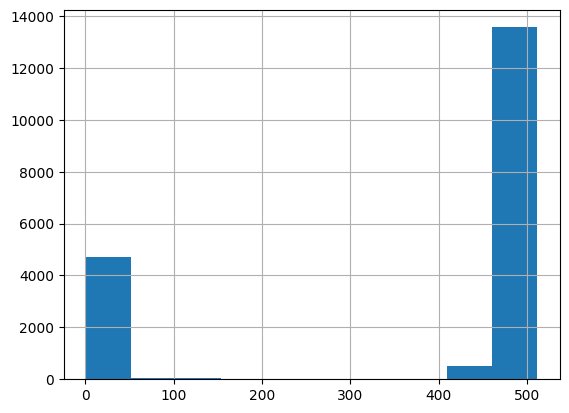

In [98]:
df_smurf_train['srv_count'].hist()

In [99]:
def save_dist_to_parquet(series, file_path, file_name):
    values, counts = np.unique(series, return_counts=True)
    probs = counts / len(series)
    distribution = pd.DataFrame()
    distribution['values']=values
    distribution['probs']=probs
    distribution.to_parquet(f'{file_path}{file_name}')

In [100]:
save_dist_to_parquet(df_smurf_train_normal['srv_count'], 'distributions/normal/', 'srv_count.parquet')
save_dist_to_parquet(df_smurf_train_smurf['srv_count'], 'distributions/smurf/', 'srv_count.parquet')

### count

<Axes: >

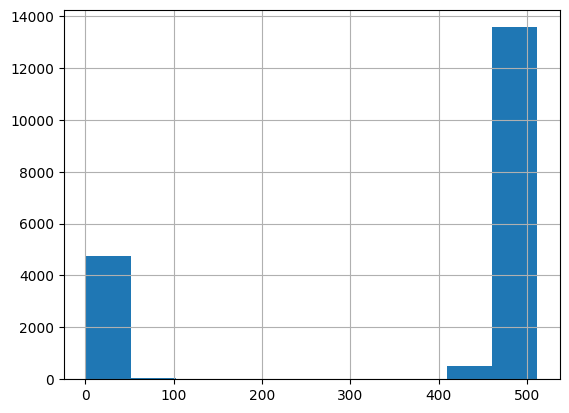

In [101]:
df_smurf_train['count'].hist()

In [102]:
save_dist_to_parquet(df_smurf_train_normal['count'], 'distributions/normal/', 'count.parquet')
save_dist_to_parquet(df_smurf_train_smurf['count'], 'distributions/smurf/', 'count.parquet')

### protocol_type

In [103]:
df_smurf_train['protocol_type'].value_counts()

protocol_type
b'icmp'    14159
b'tcp'      3795
b'udp'       949
Name: count, dtype: int64

In [104]:
pd.DataFrame(df_smurf_train_normal['protocol_type'].value_counts()/len(df_smurf_train_normal['protocol_type'])).to_parquet('distributions/normal/protocol_type.parquet')
pd.DataFrame(df_smurf_train_smurf['protocol_type'].value_counts()/len(df_smurf_train_smurf['protocol_type'])).to_parquet('distributions/smurf/protocol_type.parquet')

### dst_host_same_src_port_rate

<Axes: >

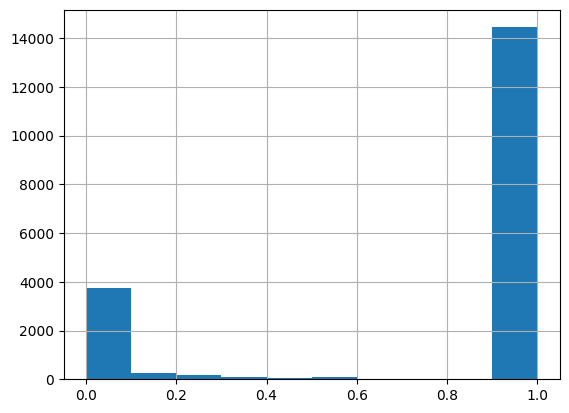

In [105]:
df_smurf_train['dst_host_same_src_port_rate'].hist()

In [106]:
save_dist_to_parquet(df_smurf_train_normal['dst_host_same_src_port_rate'], 'distributions/normal/', 'dst_host_same_src_port_rate.parquet')
save_dist_to_parquet(df_smurf_train_smurf['dst_host_same_src_port_rate'], 'distributions/smurf/', 'dst_host_same_src_port_rate.parquet')

### service

In [107]:
df_smurf_train['service'].value_counts()

service
b'ecr_i'       14111
b'http'         3042
b'smtp'          472
b'private'       368
b'domain_u'      311
b'other'         257
b'ftp_data'      192
b'urp_i'          28
b'finger'         27
b'eco_i'          20
b'ftp'            19
b'ntp_u'          15
b'telnet'         13
b'auth'            9
b'IRC'             7
b'pop_3'           7
b'time'            4
b'domain'          1
Name: count, dtype: int64

In [108]:
pd.DataFrame(df_smurf_train_normal['service'].value_counts()/len(df_smurf_train_normal['service'])).to_parquet('distributions/normal/service.parquet')
pd.DataFrame(df_smurf_train_smurf['service'].value_counts()/len(df_smurf_train_smurf['service'])).to_parquet('distributions/smurf/service.parquet')

### logged_in

In [109]:
df_smurf_train['logged_in'].value_counts()

logged_in
0    15447
1     3456
Name: count, dtype: int64

In [110]:
pd.DataFrame(df_smurf_train_normal['logged_in'].value_counts()/len(df_smurf_train_normal['logged_in'])).to_parquet('distributions/normal/logged_in.parquet')
pd.DataFrame(df_smurf_train_smurf['logged_in'].value_counts()/len(df_smurf_train_smurf['logged_in'])).to_parquet('distributions/smurf/logged_in.parquet')